# Train ALMA model

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras import backend as K
from sklearn.metrics import confusion_matrix
from PIL import Image
import pandas as pd
import time
import json
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import seaborn as sns 

Using TensorFlow backend.


In [2]:
#https://appliedmachinelearning.blog/2018/11/28/demonstration-of-facial-emotion-recognition-on-real-time-video-using-cnn-python-keras/

In [3]:
data = pd.read_pickle("../../INPUT/both_toTrain.pkl")

In [4]:
data.head() # columna de 'arrays' + columna de 'gt'

,emotion,path,array,angry,disgust,fear,happy,sadness,surprise,gt
0,sadness,fer2013/train/sadness/S071_002_00000020.png,"[[84, 85, 84, 85, 86, 87, 84, 82, 33, 25, 28, ...",0,0,0,0,1,0,"[0, 0, 0, 0, 1, 0]"
1,sadness,fer2013/train/sadness/S130_009_00000019.png,"[[58, 34, 29, 12, 0, 0, 0, 0, 1, 0, 0, 1, 25, ...",0,0,0,0,1,0,"[0, 0, 0, 0, 1, 0]"
2,sadness,fer2013/train/sadness/S125_001_00000012.png,"[[157, 129, 46, 45, 42, 43, 36, 32, 24, 29, 24...",0,0,0,0,1,0,"[0, 0, 0, 0, 1, 0]"
3,sadness,fer2013/train/sadness/S071_002_00000018.png,"[[85, 85, 85, 86, 84, 83, 84, 79, 40, 24, 27, ...",0,0,0,0,1,0,"[0, 0, 0, 0, 1, 0]"
4,sadness,fer2013/train/sadness/S106_002_00000015.png,"[[76, 75, 76, 81, 35, 34, 33, 35, 45, 39, 29, ...",0,0,0,0,1,0,"[0, 0, 0, 0, 1, 0]"


In [5]:
data['array'][0].shape

(48, 48)

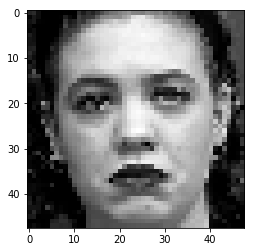

In [6]:
plt.imshow(data['array'][5], cmap="gray")

In [7]:
img_rows, img_cols, img_channels = 48, 48, 1

In [8]:
#data['array'] = data['array'].apply(lambda x: np.array([[[c] for c in i] for i in x]))

In [9]:
X = np.stack(data['array'])
X = X / 255.0 

In [10]:
y= np.stack(data['gt'])

In [11]:
y.shape

(24670, 6)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
input_shape=(img_rows, img_cols, img_channels)
num_classes=6

In [14]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19736, 48, 48) (4934, 48, 48) (19736, 6) (4934, 6)


### For the shape to be what the model needs 

In [15]:

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


In [22]:
#https://keras.io/getting-started/sequential-model-guide/

## NN convolutional 

In [23]:
'''
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
'''

"\nmodel = Sequential()\nmodel.add(Conv2D(32, kernel_size=(3, 3),\n                 activation='relu',\n                 input_shape=input_shape))\nmodel.add(Conv2D(64, (3, 3), activation='relu'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\nmodel.add(Flatten())\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(num_classes, activation='softmax'))\n\nmodel.compile(loss=keras.losses.categorical_crossentropy,\n              optimizer=keras.optimizers.Adadelta(),\n              metrics=['accuracy'])\n"

In [24]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(48, 48 ,1), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
adam = Adam(decay=decay)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,verbose=1, batch_size=50)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)      

In [ ]:
'''
filepath='Checkpoint_{epoch:02d}_{val_accuracy:.2f}'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
'''

In [25]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Accuracy: 67.09%
Test loss: 1.4502774185263583
Test accuracy: 0.6708552837371826


In [ ]:
'''
batch_size = 20
epochs = 25

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))
'''

In [ ]:
'''
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
'''

## Save the model

In [26]:
moment=time.localtime()
name='Model_{}_{}-{}-{}.h5'.format(model.history.history["val_accuracy"][-1],moment[2],moment[3],moment[4])
model.save(name)

In [27]:
import json

model_json = model.to_json()
with open(name+'.json', "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights(name)

## Prediction <!>

In [28]:
class_names = ('Angry', 'Disgust','Fear','Happy','Sad','Surprise')

[0 5 3 ... 3 2 4]
[2 5 3 ... 3 2 4]


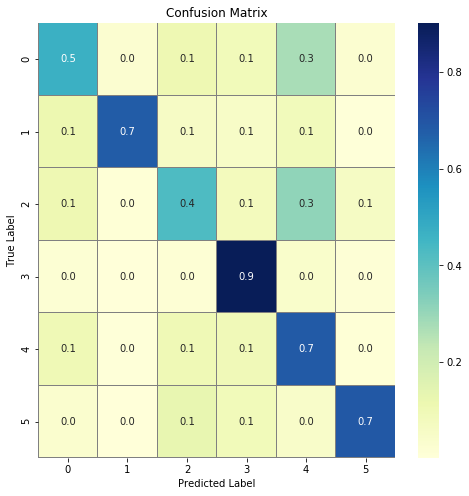

In [29]:
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
print(Y_pred_classes)
Y_true = np.argmax(y_test,axis = 1)
print(Y_true)
# compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="YlGnBu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Load model


In [16]:
with open('../../models/Model_0.6708552837371826_17-0-29.h5.json','r') as f:
    model_json = json.load(f)
model = model_from_json(model_json)
model.load_weights('../../models/Model_0.6708552837371826_17-0-29.h5')

### predict with test 

[4.4421231e-08 3.4607156e-20 1.4903056e-11 1.0000000e+00 1.7439291e-08
 5.3215543e-13]
Probs -> angry:0.00000 disgust:0.00000 fear:0.00000 happy:1.00000 sadness:0.00000 surprise:0.00000
(1, 48, 48, 1)


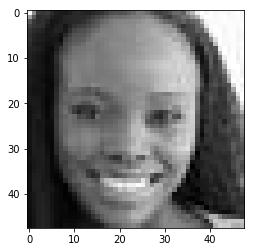

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

img = X_test[150]
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
print("Probs -> angry:{0:.5f} disgust:{1:.5f} fear:{2:.5f} happy:{3:.5f} sadness:{4:.5f} surprise:{5:.5f}".format(pred[0],pred[1],pred[2],pred[3],pred[4],pred[5]))
print(np.expand_dims(img,axis=0).shape)
plt.imshow(Image.fromarray(img.squeeze()*255))

### predict with outsider 

In [23]:
face_cascade = cv2.CascadeClassifier('../../files/haarcascade_frontalface_default.xml')

In [24]:
def transfImag(path):
    print ('transforming image from {}'.format(path))

    input_img=cv2.imread(path)
    input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(input_img, 1.25, 6)
    x,y,w,h = faces[0]
    img_data= input_img[y:y+h,x:x+w]
    img_data=cv2.resize(img_data,(48,48))
    
    img_data = np.stack(img_data)
    img_data = img_data / 255.0
    
    return img_data

In [25]:
transfImag('../../INPUT/6.jpeg')

transforming image from ../../INPUT/6.jpeg


array([[0.60784314, 0.62352941, 0.30588235, ..., 0.26666667, 0.25490196,
        0.2627451 ],
       [0.61568627, 0.43921569, 0.14509804, ..., 0.09411765, 0.14901961,
        0.09803922],
       [0.61960784, 0.29411765, 0.1254902 , ..., 0.04705882, 0.05098039,
        0.03921569],
       ...,
       [0.04705882, 0.05490196, 0.03921569, ..., 0.01568627, 0.01568627,
        0.01568627],
       [0.03137255, 0.04705882, 0.0627451 , ..., 0.01568627, 0.01568627,
        0.01568627],
       [0.04313725, 0.05098039, 0.04705882, ..., 0.02745098, 0.03137255,
        0.01568627]])

-----------------------------------------------------------------------------------------------------------------

transforming image from ../../INPUT/6.jpeg
(1, 48, 48, 1)
Probs -> angry:0.00003 disgust:0.00000 fear:0.00000 happy:0.99994 sadness:0.00003 surprise:0.00000


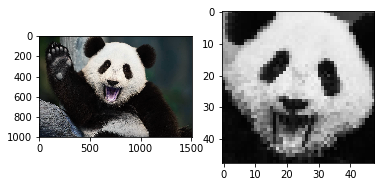

In [27]:
PIC = transfImag('../../INPUT/6.jpeg') # transform pic
input_img=cv2.imread('../../INPUT/6.jpeg') # get the array of the original pic

plt.subplot(121)
plt.imshow(input_img) # original pic
plt.subplot(122)
plt.imshow(Image.fromarray(PIC.squeeze()*255)) # transformed pic

PIC = np.expand_dims(PIC,axis=0).reshape(np.expand_dims(PIC,axis=0).shape[0], 48, 48, 1)
print(PIC.shape)
pred2 = model.predict(PIC)[0]
print("Probs -> angry:{0:.5f} disgust:{1:.5f} fear:{2:.5f} happy:{3:.5f} sadness:{4:.5f} surprise:{5:.5f}".format(pred2[0],pred2[1],pred2[2],pred2[3],pred2[4],pred2[5]))